In [2]:
from fastai.vision.all import *

The CSV for titanic data is tabular, so I guess we should somehow be able to use it, right?

It's kind of sad that so much of this stuff is just data cleaning.

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
key = user_secrets.get_secret("key")
username = user_secrets.get_secret("username")

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = username
os.environ['KAGGLE_KEY'] = key

In [5]:
!kaggle competitions download -c digit-recognizer

 33%|████████████▍                         | 5.00M/15.3M [00:00<00:00, 44.8MB/s]
100%|███████████████████████████████████████| 15.3M/15.3M [00:00<00:00, 106MB/s]


In [6]:
print(os.listdir('/kaggle/working'))
!unzip /kaggle/working/digit-recognizer.zip -d digit-recognizer
print(os.listdir('/kaggle/working/digit-recognizer'))

['.virtual_documents', '__notebook_source__.ipynb', 'digit-recognizer.zip']
Archive:  /kaggle/working/digit-recognizer.zip
  inflating: digit-recognizer/sample_submission.csv  
  inflating: digit-recognizer/test.csv  
  inflating: digit-recognizer/train.csv  
['sample_submission.csv', 'test.csv', 'train.csv']


In [7]:
import pandas as pd
# Load the CSV file into a Pandas DataFrame
train_df = pd.read_csv('/kaggle/working/digit-recognizer/train.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Split the DataFrame into image pixels and labels
pixels = train_df.drop('label', axis=1)
pixels.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
labels = train_df['label']
labels.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [11]:
pixels_arr = 255 - pixels.values 
pixels_arr = pixels_arr.reshape(-1, 28, 28).astype(np.uint8)

In [12]:
from PIL import Image
for i in range(len(pixels_arr)):
    img = Image.fromarray(pixels_arr[i], 'L')
    if i < 10:
        display(img)
    filename = f'label_{labels[i]}_index_{i}.png'  # Customize filename based on label and index
    img.save(filename)

In [13]:
def get_label(filename):
    return filename.split('_')[1]
print("file: ", os.listdir()[0])
print("label: ", get_label(os.listdir()[0]))

file:  label_1_index_15711.png
label:  1


In [14]:
path = os.getcwd()
dls = ImageDataLoaders.from_name_func(
    path,
    get_image_files(path),
    valid_pct=0.2,
    seed=42,
    label_func=get_label,
    item_tfms=Resize(224),
)

Finally, let's train the model.

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

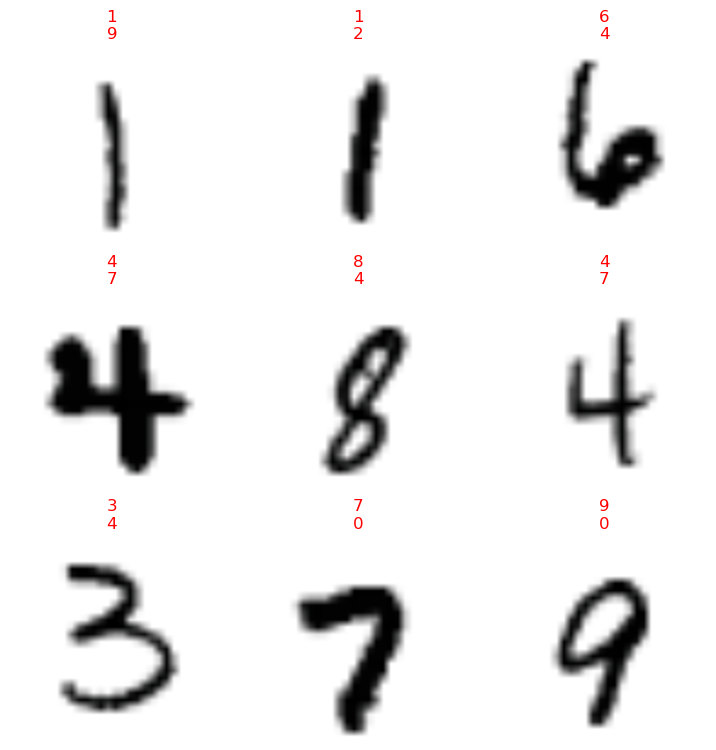

In [16]:
learner = vision_learner(dls, resnet34, metrics=error_rate)
learner.show_results()

In [17]:
learner.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.181972,0.092351,0.030833,02:19


epoch,train_loss,valid_loss,error_rate,time
0,0.046385,0.021726,0.006190,02:32


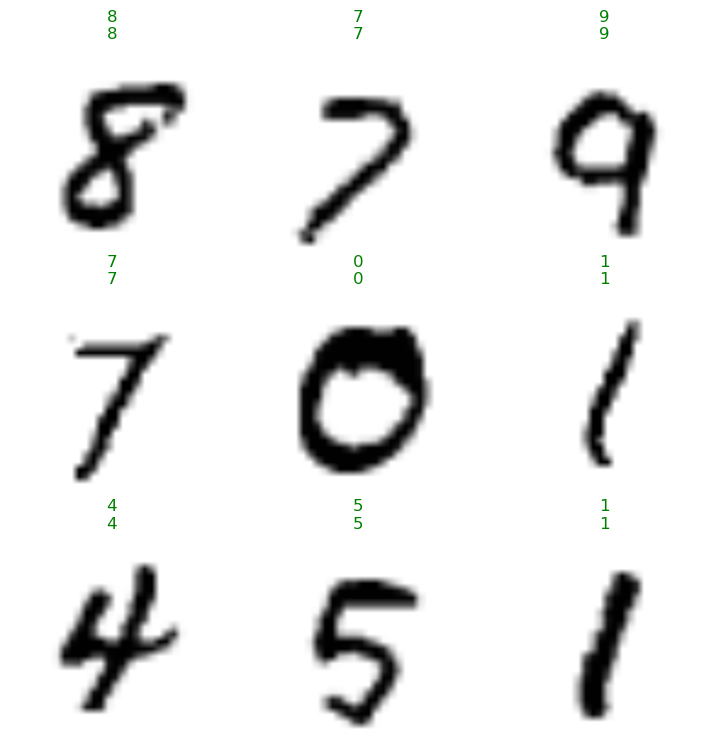

In [18]:
learner.show_results()

# Fine tuned now

Ok, model seems to be fine-tuned, now let's try to run it on the actual data in test.csv.

In [19]:
test_df = pd.read_csv('/kaggle/working/digit-recognizer/test.csv')
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
test_pixels_arr = 255 - test_df.values 
test_pixels_arr = test_pixels_arr.reshape(-1, 28, 28).astype(np.uint8)
for image in os.listdir():
    if image.startswith('test_') and image.endswith('.png'):
        os.remove(image)
for i in range(len(test_pixels_arr)):
    img = Image.fromarray(test_pixels_arr[i], 'L')
    if i < 10:
        display(img)
    filename = f'test_index_{i}.png'  # Customize filename based on label and index
    img.save(filename)

In [22]:
print(len(test_pixels_arr))

28000


In [44]:
def get_image_id(path):
    return int(path.split('_')[2].split('.')[0])
images = sorted([path for path in os.listdir() if path.startswith('test_') and path.endswith('.png')], key=get_image_id)
print(len(images))
namespace = SimpleNamespace(data = images)

28000


In [48]:
answers = []

for index, image in enumerate(namespace.data):
    with learner.no_bar():
        digit, _, probabilities = learner.predict(image)
        answers.append((get_image_id(image) + 1, digit))
        if index % 1000 == 0:
            print(f"index done: {index}")

index done: 0
index done: 1000
index done: 2000
index done: 3000
index done: 4000
index done: 5000
index done: 6000
index done: 7000
index done: 8000
index done: 9000
index done: 10000
index done: 11000
index done: 12000
index done: 13000
index done: 14000
index done: 15000
index done: 16000
index done: 17000
index done: 18000
index done: 19000
index done: 20000
index done: 21000
index done: 22000
index done: 23000
index done: 24000
index done: 25000
index done: 26000
index done: 27000


In [55]:
print(len(answers))
answers[:10]

28000


[(1, '2'),
 (2, '0'),
 (3, '9'),
 (4, '0'),
 (5, '3'),
 (6, '7'),
 (7, '0'),
 (8, '3'),
 (9, '0'),
 (10, '3')]

In [57]:
df = pd.DataFrame(data = answers, 
                  columns = ['ImageId', 'Label'])
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [60]:
df.to_csv('answers.csv')
print('answers.csv' in os.listdir())

True


In [61]:
from IPython.display import FileLink
FileLink(r'answers.csv')

/kaggle/working/answers.csv